## $q$-means ($\delta$-$k$-means) simulations on MNIST dataset

##### NeurIPS Submission - May 2019

This code has been written by Jonas Landman, PhD Student @IRIF, Université Paris Diderot & École Polytechnique, Paris, France

landman@irif.fr

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import itertools
import random

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from mnist import MNIST

from scipy.stats import mode

import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
np.warnings.filterwarnings('ignore')

### Loading the MNIST Dataset

training & testing datasets

In [5]:
path = '***your-path-to-mnist***'
mndata = MNIST(path)
    
X, y = mndata.load_training()
y = np.array(y)
X = np.array(X)

X_, y_ = mndata.load_testing()
y_ = np.array(y_)
X_ = np.array(X_)

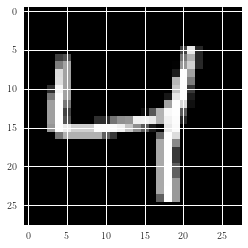

label: 4


In [6]:
def image_print(x):
    pixels = x.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    
image_print(X[2])
print("label: "+str(y[2]))

### Normalization Preprocessing

Our requirement is that the minimum norm of the dataset should be equal to one

We note as $\eta$ (eta) the maximunm squared norm of the dataset

In [6]:
# "Norm preprocessing: divide by the minimum norm"

print("data: X of shape (number, dimension)={}".format(np.shape(X)))

norms = [np.linalg.norm(x) for x in X]
print("\n before normalization:")
print("min norm (X): {0} / max norm (X): {1}".format(np.min(norms),np.max(norms)))
print("condition number of X: %f"%np.linalg.cond(X))
print("$\eta$ = {}".format(np.max(norms)**2))

min_norm = np.min(norms)
Xnorm = X/min_norm
norms = [np.linalg.norm(x) for x in Xnorm]
print("\n after normalization:")
print("min norm (Xnorm): {0} / max norm (Xnorm): {1}".format(np.min(norms),np.max(norms)))
print("condition number of Xnorm: %f"%np.linalg.cond(Xnorm))
norms = [np.linalg.norm(x) for x in Xnorm]
print("$\eta$ = {}".format(np.max(norms)**2))

data: X of shape (number, dimension)=(60000, 784)

 before normalization:
min norm (X): 910.3059925102108 / max norm (X): 4380.656685931916
condition number of X: inf
$\eta$ = 19190153.0

 after normalization:
min norm (Xnorm): 1.0 / max norm (Xnorm): 4.812290286974881
condition number of Xnorm: inf
$\eta$ = 23.158137806112784


### Tools and $\delta$-$k$-means preparation

#### functions for plots

In [10]:
# put to 1 to activate
plot_data_on = 0 # to plot the data points with labels 
plot_accuracy_on = 0 # to plot accuracy evolution
plot_random_choice_on = 0 # (only for delta-k-means) to plot the evolution of the number of random decisions


# function to plot k-means evolution
def plot_regular_clusters(X,labels,accuracy):
    if plot_data_on or plot_accuracy_on:
        fig = plt.figure(figsize=(14, 8))
        if plot_data_on:
            ax1 = fig.add_subplot(231)
            ax1.set_title("Clusters")
            ax1.scatter(X[:, 0], X[:, 1], c=labels, s=2, cmap='viridis'); 
        if plot_accuracy_on:
            ax2 = fig.add_subplot(232)
            ax2.set_title("Accuracy (%)")
            ax2.plot(accuracy, c='r')
        plt.show()
        
        
# function to plot delta-k-means evolution
def plot_delta_clusters(X,labels,random_choices,accuracy):
    if plot_data_on or plot_accuracy_on or plot_random_choice_on:
        fig = plt.figure(figsize=(14, 8))
        if plot_data_on:
            ax1 = fig.add_subplot(231)
            ax1.set_title("Clusters")
            ax1.scatter(X[:, 0], X[:, 1], c=labels,s=2, cmap='viridis');
        if plot_accuracy_on:
            ax2 = fig.add_subplot(232)
            ax2.set_title("Accuracy (%)")
            ax2.plot(accuracy, c='r') 
        if plot_random_choice_on:
            ax3 = fig.add_subplot(233)
            ax3.set_title("Random choices of centers (delta)")
            ax3.plot(random_choices)
        plt.show()

#### functions for assigning labels

Given a set of vectors $X$, a set of centroids, return to which center belongs each point

If several centroids have almost the same distance (up to $\delta$) to one vector, the $\delta$-$k$-means rule is to assign randomly a centroids among them

In [ ]:
def label_with_delta_squared(X,centers,delta): #given X (points) and centers: 2 numpy arrays
    labels = []
    count = 0 #to count the number of times we chose a random center
    for dist_array in pairwise_distances(X,centers): #dist_array is the array of distances between on element Xi of X and each cluster! 
        dist_array = np.square(dist_array) #THIS IS THE SQUARED DISTANCE MODIFICATION!
        mindist = np.min(dist_array) #distance between Xi and its closest clusters
        normalmin = [np.argmin(dist_array)] # index of the clusters closest to Xi
        close_dist = set([dist for dist in dist_array if abs(dist-mindist)<delta]) #array of all distance of dist_array if they are delta-close to mindist 
        deltamin = [i for i, item in enumerate(dist_array) if item in close_dist] #index of delta-close centers 
        deltachoice = random.choice(deltamin) #choose randomly one of the delta-close centers
        labels.append(deltachoice)
        if deltamin!=normalmin:
            count+=1
    #print("DELTA K-MEANS: %d random choices of centers over %d"%(count,len(X)))
    return np.array(labels),count

def lossfunction(X,labels,centers):
    N = len(X)
    loss = 1/np.sqrt(N)*np.sum([np.linalg.norm(X[i]-centers[labels[i]]) for i in range(N)])
    return loss

## Algorithms: $k$-means & $\delta$-$k$-means

We provide two functions that iterate on a dataset util finding the $k$ centroids that classify the data

### 1/ $k$-means implementation

In [29]:
def find_clusters_regular(X, n_clusters, threshold, limit=50):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed) #rseed comes from elsewhere: very important to remain consistant
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i] 
    #variables to follow the kmeans
    step = 0
    loss = []
    accuracy = []
    
    
    while True: #repeat until convergence each reached
        step+=1
        
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers) #REGULAR KMEANS
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. put the right labels on points
        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
        
        # measure accuracy & loss
        loss_step = lossfunction(X,labels_real,new_centers)
        loss.append(loss_step)
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)
        
        if step>1:
            
            if step%10==0:
                plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels,accuracy)
                
            # 2d. Check for convergence. BREAK if it finishes
            if abs(loss_step - loss[-2])<threshold or step >= limit:
                print("END: BELOW THRESHOLD")
                print("step: {}".format(step))
                plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels_real,accuracy)
                break                   
               
        centers = new_centers #update the centers
    print("accuracy: {}".format(accuracy[-1]))
    
    return centers, labels_real, accuracy

### 1/ $\delta$-$k$-means implementation

- we use a specific rule for assigning labels for each vector, defined above: *label_with_delta_squared()*
- we add a gaussian noise on the centroids

In [28]:
def find_clusters_delta_squared(X, n_clusters, delta, threshold, limit=50):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed) #rseed comes from elsewhere: very important to remain consistant
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    #variables to follow the algorithm
    step = 0
    random_choices = [] # count how many random decisions have been taken
    loss = []
    accuracy = []
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels, count = label_with_delta_squared(X,centers,delta) #DELTA KMEANS
        random_choices.append(count) # number of random decisions that have been taken
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        #2.c add gaussian noise on the centroids, of magnitude delta/2
        new_centers = []
        for i in range(n_clusters):
            centroid = X[labels == i].mean(0)
            noise = np.random.normal(0,0.1,len(centroid))
            factor = (delta/2)/np.linalg.norm(noise)
            noise *= factor
            centroid += noise
            new_centers.append(centroid)
        new_centers = np.array(new_centers)
        
        #2.d put the right labels on points
        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
        
        # measure accuracy & loss
        loss_step = lossfunction(X,labels_real,new_centers)
        loss.append(loss_step)
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)

        if step>1:
            
            if step%5==0:
                plot_delta_clusters(PCA(n_components=2).fit_transform(X),labels_real,random_choices, accuracy)


            # 2c. Check for convergence. BREAK if it finishes
            if abs(loss_step - loss[-2])<threshold or step >= limit:
                print("END: BELOW THRESHOLD")
                print("step: {}".format(step))
                plot_delta_clusters(PCA(n_components=2).fit_transform(X),labels_real,random_choices, accuracy)
                break
                
        centers = new_centers
    print("accuracy: {}".format(accuracy[-1]))

    return centers, labels_real, random_choices, accuracy

# $k$-means & $\delta$-$k$-means experiment on MNIST Dataset

### Experiment #1: MNIST with PCA Preprocessing
- Reduce dimension with PCA down to 40 dimensions
- Normalize to have minimum norm equal to one

In [8]:
Xpca = PCA(n_components = 40).fit_transform(X)
norms = [np.linalg.norm(x) for x in Xpca]
min_norm = np.min(norms)

dataset = Xpca/min_norm

print("condition number of X: %f"%np.linalg.cond(dataset))

norms = [np.linalg.norm(x) for x in dataset]
print("min norm : {0} / max norm: {1}".format(np.min(norms),np.max(norms)))

#eta is the maximum squared norm of the dataset
eta = np.max(norms)**2
print("eta: %f"%eta)

# the average eta is the average squared norm of the dataset
average_eta = np.average(np.square(norms))
print("average_eta: %f"%average_eta)

condition number of X: 4.535409
min norm : 1.0 / max norm: 2.8706362774044707
eta: 8.240553
average_eta: 2.628179


#### Prepare the testset with the exact same preprocessing

In [284]:
testpca =  PCA(n_components = 40).fit_transform(X_) #X_ is the MNIST test set
norms = [np.linalg.norm(x) for x in testpca]
min_norm = np.min(norms)
testset = testpca/min_norm

#### test: run regular $k$-means on the data and plot the evolution

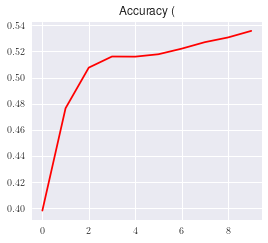

END: BELOW THRESHOLD
step: 18


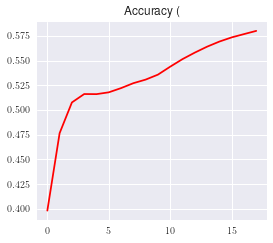

accuracy: 0.5799666666666666


In [22]:
rseed = np.random.randint(0,50) # used to random initialization of the centroids
plot_accuracy_on = 1 #put 1 to see the evolution of the accuracy
find_clusters_regular(dataset, n_clusters=10, threshold=0.01, limit=50)

### Run the experiment

##### Repeat for different random trials (random seed numbers are used for the initialization of the centroids):
- run $k$-means, save the results in an array
- for differents values of $\delta$ do:
    - run $k$-means & $\delta$-$k$-means, save the results

_note: keeping track of the random seed numbers if very important for consistancy and reproducibility_

In [13]:
deltas = [0.2,0.3,0.4,0.5]

In [286]:
plot_accuracy_on = 0 #don't show plots because it's too long

results = [] #store the results here

for i in range(5): # try 5 random trial
    
    rseed = np.random.randint(0,50)
    print("\n*** ##%d## RSEED = %d***"%(i,rseed))
    
    #run k-means
    print("---- : KMEANS-----")
    centroids_regular, label_regular, accuracy_regular = find_clusters_regular(dataset, n_clusters=10, threshold=0.01)
    
    #run delta-k-means for different value of delta
    accuracy_deltas_squared = []
    labels_delta_squared = []
    centroids_deltas_squared = []
    for delta in deltas: 
        print("----: DMEANS_squared: %f-----"%delta)
        centroids, label,_,accuracy = find_clusters_delta_squared(dataset, 
                                                                  n_clusters=10, 
                                                                  delta=delta, 
                                                                  threshold=0.01)
        accuracy_deltas_squared.append(accuracy)
        labels_delta_squared.append(label)
        centroids_deltas_squared.append(centroids)
        
    results.append([rseed,
                    deltas, 
                    accuracy_regular, 
                    accuracy_deltas_squared, 
                    label_regular,
                    labels_delta_squared, 
                    centroids_regular, 
                    centroids_deltas_squared])



*** ##0## RSEED = 0***
---- : KMEANS-----
END: BELOW THRESHOLD
step: 25
accuracy: 0.6164166666666666
----: DMEANS_squared: 0.200000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.60605
----: DMEANS_squared: 0.300000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.5623666666666667
----: DMEANS_squared: 0.400000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.5534833333333333
----: DMEANS_squared: 0.500000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.51705

*** ##1## RSEED = 31***
---- : KMEANS-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.5874833333333334
----: DMEANS_squared: 0.200000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.5819833333333333
----: DMEANS_squared: 0.300000-----
END: BELOW THRESHOLD
step: 50
accuracy: 0.5716833333333333
----: DMEANS_squared: 0.400000-----
END: BELOW THRESHOLD
step: 33
accuracy: 0.5523166666666667
----: DMEANS_squared: 0.500000-----
END: BELOW THRESHOLD
step: 34
accuracy: 0.5338333333333334

*** ##2## RSEED = 43***
---- : KMEANS-----
END: BELOW TH

### Plot the results

##### For each random trial: plot the evolution of the accuracy over the iteration, for each algorithm

results #0, rseed=0
results #1, rseed=31
results #2, rseed=43
results #3, rseed=3
results #4, rseed=23


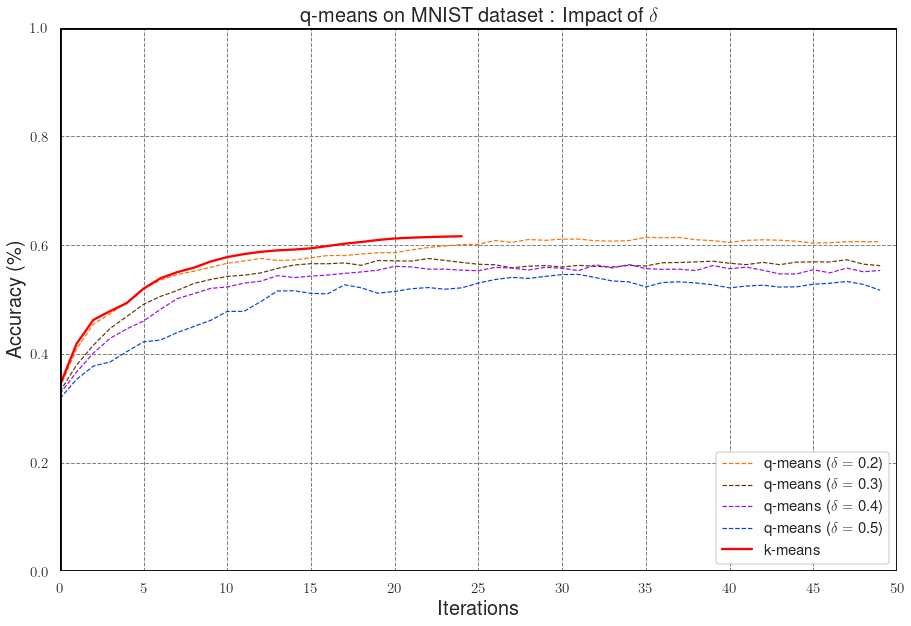

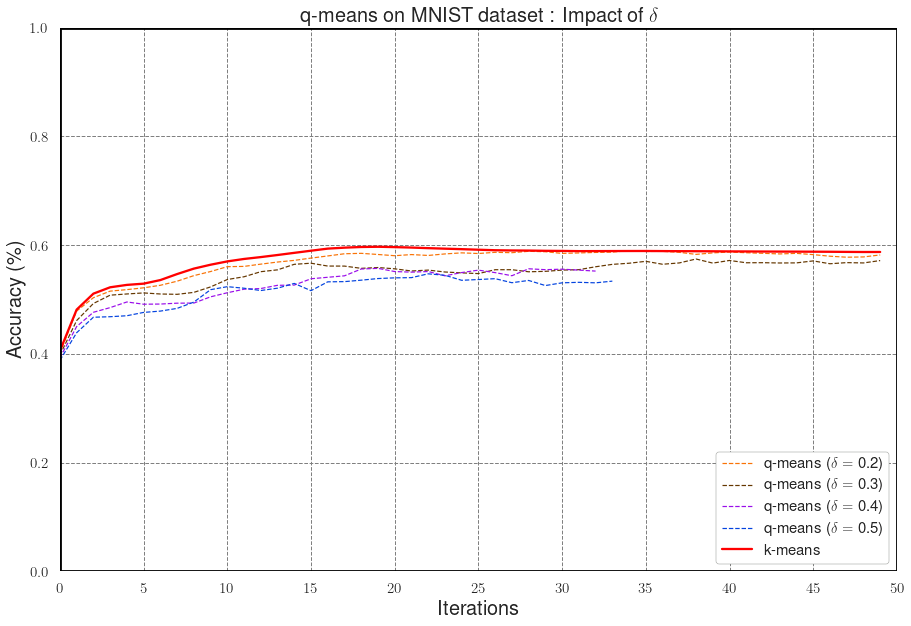

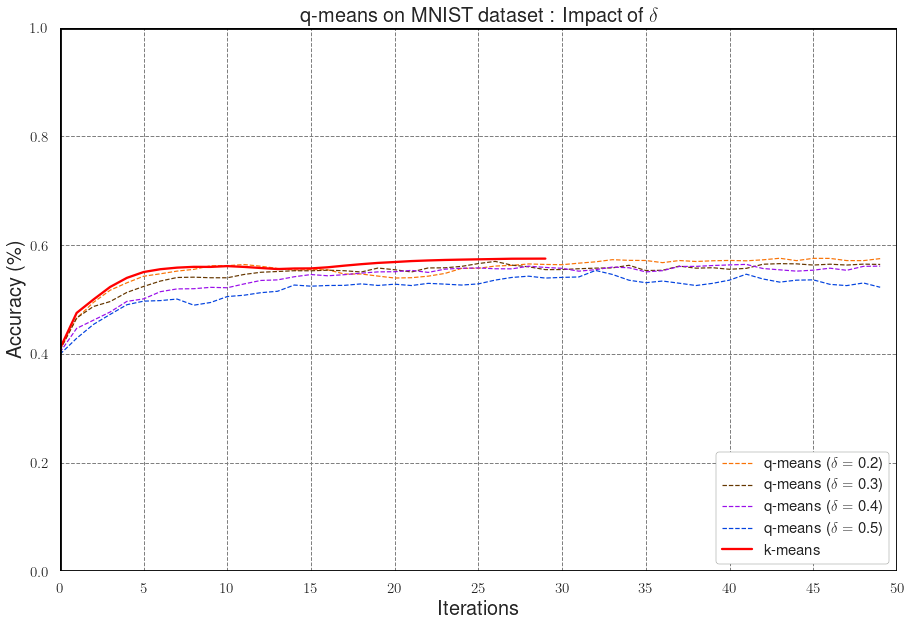

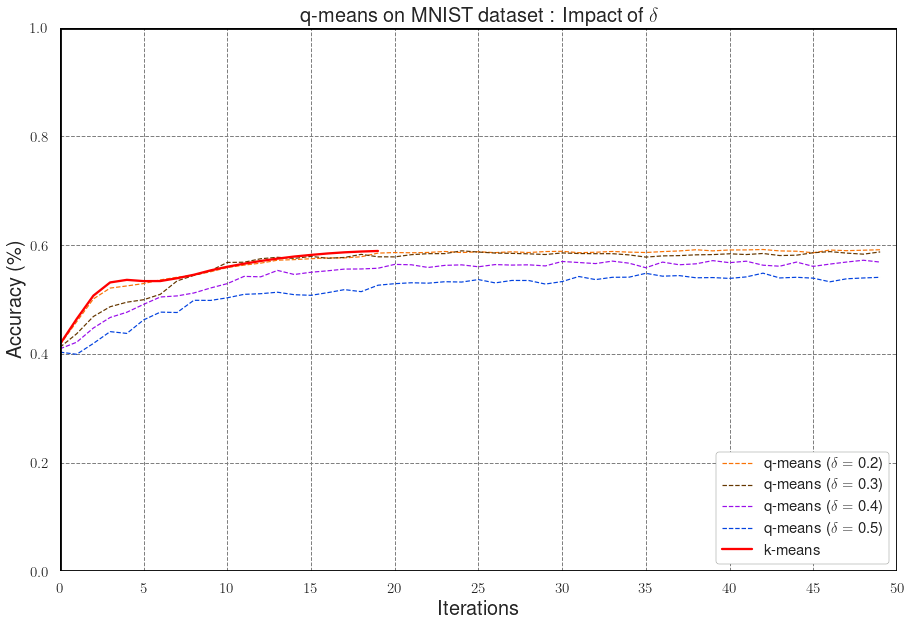

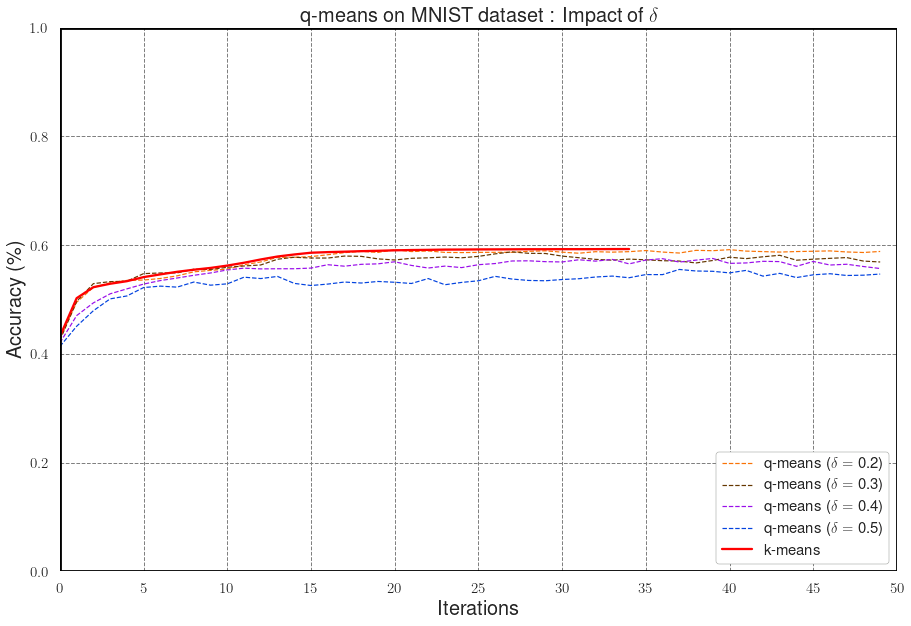

In [293]:
plt.style.use("seaborn-poster")

norms = [np.linalg.norm(x) for x in dataset]
eta = np.max(norms)**2

for r in range(len(results)):
    res = results[r]
    print('results #{}, rseed={}'.format(r,res[0]))

    accuracy_regular = res[2]
    accuracy_deltas = res[3]
    deltas = res[1]
    rseed = res[0]
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('xkcd:white')
    ax.grid(which='both', color="grey")
    plt.grid(linestyle='--', linewidth=1)
    xkcd_col = ['xkcd:orange','xkcd:brown','xkcd:violet','xkcd:blue','xkcd:green','xkcd:grey']


    for j in range(len(deltas)):
        val = str(np.round(eta/deltas[j]))
        delta_str = str(np.round(deltas[j],3))
        plt.plot(accuracy_deltas[j], 
                 c=xkcd_col[j], 
                 label="q-means ($\delta=$ %s)"%(delta_str), 
                 linestyle='--', linewidth=1.2)

    plt.plot(accuracy_regular, 'r',linewidth=2.3, label="k-means")

    font = 20
    
    xsize = np.max([len(accuracy_regular),np.max([len(x) for x in accuracy_deltas])])
    xlimit = [0,xsize]
    ylimit = [0,1]

    plt.title("q-means on MNIST dataset : Impact of $ \delta$ ", fontsize=font)
    plt.xlabel("Iterations", fontsize=font)
    plt.ylabel("Accuracy (\%)", fontsize=font)
    plt.xlim(xlimit[0],xlimit[1])
    plt.ylim(ylimit[0],ylimit[1])
    plt.xticks(fontsize=0.75*font)
    plt.yticks(fontsize=0.75*font)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.axhline(y=ylimit[0], color='k')
    ax.axvline(x=xlimit[0], color='k')
    ax.axhline(y=ylimit[1], color='k')
    ax.axvline(x=xlimit[1], color='k')

    lgnd = ax.legend(loc='lower right', ncol=1, frameon=True, framealpha=1, prop={'size': 0.75*font})
    lgnd.get_frame().set_facecolor('xkcd:white')
    lgnd.get_frame().set_edgecolor('xkcd:grey')
    
    
    
    name = 'mnist_pca40_rseed%d.png'%rseed
    fig.savefig(name, bbox_inches='tight')
    write_result(r,'pca_%s'%rseed)

#plt.show()

### Accuracy metrics

The centroids returned by our previous experiments are used on the trainset and the testset. We wnat to know how good are these centroids.

We define some usual metrics to assert the quality of our clustering,
taken from https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

We define a new metric: RMSEC (Root Mean Squared Error of Centroids) to compare the centroids returned by $\delta$-$k$-means and $k$-means



In [14]:
def cluster_from_centroids(centroids, data, true_labels):
    labels = pairwise_distances_argmin(data, centroids) #find the labels for each point given the centroids
    
    predicted_labels = np.zeros_like(true_labels)
    for i in range(10):
        mask = (labels == i)
        predicted_labels[mask] = mode(true_labels[mask])[0]
        
    # compute accuracy metrics
    results = [accuracy_score(true_labels,predicted_labels),
                 metrics.homogeneity_score(true_labels, predicted_labels),
                 metrics.completeness_score(true_labels, predicted_labels),
                 metrics.v_measure_score(true_labels, predicted_labels),
                 metrics.adjusted_rand_score(true_labels, predicted_labels),
                 metrics.adjusted_mutual_info_score(true_labels,  predicted_labels)]
    return results

def rmse_centroids(centroids_regular, centroids_delta):
    dist_arr = []
    k = len(centroids_regular)
    for t in pairwise_distances(centroids_regular, centroids_delta):
        dist = np.min(t)
        dist_arr.append(dist**2)
    rmse = (1/k)*np.sqrt(np.sum(dist_arr))
    return rmse

In [16]:
# Write a file

def write_result(r,name):
    with open(name+'.txt', 'w') as f:

        #print("[accuracy, homogeneity, completeness, v_measure, adjusted_rand, adjusted_mutual_info]\n")
        f.write("[accuracy, homogeneity, completeness, v_measure, adjusted_rand, adjusted_mutual_info]\n")


        res = results[r]
        #print('\n\n-----results #{}, rseed={}------\n'.format(r,res[0]))
        f.write('\n\n-----results #{}, rseed={}------\n'.format(r,res[0]))


        #regular kmeans
        test_benchmark_regular = cluster_from_centroids(res[6],testset,y_) #y_ are the true test labels
        train_benchmark_regular = cluster_from_centroids(res[6],dataset,y) #y are the true train labels
        f.write(" \n")
        #print("\n\n**KMEANS REGULAR**")
        f.write("**KMEANS REGULAR**")
        f.write(" \n")
        #print("test")
        f.write("test")
        f.write(" \n")
        #print(test_benchmark_regular)
        f.write(str(test_benchmark_regular))
        f.write(" \n")
        #print("train")
        f.write("train")
        f.write("\n ")
        #print(train_benchmark_regular)
        f.write(str(train_benchmark_regular))
        f.write(" \n")


        #delta kmeans
        #print("\n\n **DELTA KMEANS**")
        f.write("\n **DELTA KMEANS**")
        f.write(" \n")
        for j in range(len(deltas)):
            #print("\n %d: delta = %f"%(j, res[1][j]))
            f.write("\n %d: delta = %f"%(j, res[1][j]))
            f.write(" \n")
            test_benchmark_delta = cluster_from_centroids(res[7][j],testset,y_) #y_ are the true test labels
            train_benchmark_delta = cluster_from_centroids(res[7][j],dataset,y) #y are the true train labels
            #print("test")
            f.write("test")
            f.write(" \n")
            #print(test_benchmark_delta)
            f.write(str(test_benchmark_delta))
            f.write(" \n")
            #print("train")
            f.write("train")
            f.write(" \n")
            #print(train_benchmark_delta)
            f.write(str(train_benchmark_delta))
            f.write(" \n")

        #print("\n\n **RMSE CENTROIDS: kmeans vs delta-kmeans**")
        f.write("\n\n **RMSE CENTROIDS: kmeans vs delta-kmeans**")
        f.write(" ")
        for j in range(len(deltas)):
            #print("\n %d: delta = %f"%(j, res[1][j]))
            f.write("\n %d: delta = %f"%(j, res[1][j]))
            f.write(" \n")
            #print(rmse_centroids(res[6],res[7][j]))
            f.write(str(rmse_centroids(res[6],res[7][j])))
            f.write(" \n")